# How Robust are Audio Embeddings for Polyphonic Sound Classification?

**Jakob Abeßer, Sascha Grollmisch, Meinard Müller, IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2023**

This jupyter notebook reproduces all experiments and figures for the article.

In [10]:
import numpy as np
import librosa
import os
import glob
import pickle
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import shapiro
from sklearn.metrics import average_precision_score
import tensorflow as tf

In [12]:
print("numpy version: ", np.__version__)
print("librosa version: ", librosa.__version__)
print("sns version: ", sns.__version__)
print("pandas version: ", pd.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("tensorflow version: ", tf.__version__)

numpy version:  1.18.5
librosa version:  0.8.1
sns version:  0.11.1
pandas version:  1.3.1
matplotlib version:  3.4.3
tensorflow version:  2.3.0


In [2]:
# plotting parameters
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
pl.rcParams.update(pl.rcParamsDefault)
fo_si = 16        # fontsize 

In [3]:
# directories TODO
dir_data = 'data'
# dir_tmp = 'C:/temp/2022_embedding_space_inspection/'
# dir_wav = 'C:/datasets/ESC50MixBlend'
dir_results = 'results'

In [4]:
# global paramters
fs = 44100        # sample rate in Hz
n_samples = 5*fs  # audio length in samples
n_gain_steps = 6  # number of values for mixing coefficient $g$

## Import pre-computed embeddings

In [12]:
# embedding types we want to investigate
# (alphabetic order, first NTARs, then DAEs)
emb_labels_basic = ('MelSpec', 'MFCC', 'Kumar', 'OpenL3', 'PANN', 'PaSST', 'VGGish')
emb_labels = []
for emb_lab in emb_labels_basic:
    emb_labels.append(emb_lab)
print(emb_labels)

['MelSpec', 'MFCC', 'Kumar', 'OpenL3', 'PANN', 'PaSST', 'VGGish']


In [13]:
# load file prefixes
fn_p = os.path.join(dir_data, 'prefix_list.p')
with open(fn_p, 'rb') as f:
    prefix_list = pickle.load(f)
n_files = len(prefix_list)
print(n_files, ' files')

30000  files


In [14]:
# Import all pre-computed embeddings
fn_emb = os.path.join(dir_data, 'all_emb.p')

# load from pickle file
with open(fn_emb, 'rb') as f:
    emb_agg = pickle.load(f)
        
for k in emb_agg.keys():
    # print(k, emb_agg[k].shape)
    print(f"Embedding matrix shape of {emb_lab}: {emb_agg[k].shape}")

# get embedding lengths
emb_len = {}
for emb_lab in emb_labels:
    emb_len[emb_lab] = emb_agg[emb_lab].shape[1]
    print(f"Dimensions of {emb_lab}: {emb_len[emb_lab]}")

Embedding matrix shape of VGGish: (30000, 640)
Embedding matrix shape of VGGish: (30000, 65)
Embedding matrix shape of VGGish: (30000, 5120)
Embedding matrix shape of VGGish: (30000, 2560)
Embedding matrix shape of VGGish: (30000, 2560)
Embedding matrix shape of VGGish: (30000, 6475)
Embedding matrix shape of VGGish: (30000, 640)
Dimensions of MelSpec: 640
Dimensions of MFCC: 65
Dimensions of Kumar: 5120
Dimensions of OpenL3: 2560
Dimensions of PANN: 2560
Dimensions of PaSST: 6475
Dimensions of VGGish: 640


In [15]:
# add very small noise values to avoid numeric problems due to possible constant embedding dimensions
for emb_lab in emb_labels:
    maxval = np.max(np.abs(emb_agg[emb_lab])) 
    emb_agg[emb_lab] += 0.00001*maxval*np.random.randn(*emb_agg[emb_lab].shape)

In [16]:
# load class id & labels
class_id = np.load(os.path.join(dir_data, f"class_id.npy"))
with open(os.path.join(dir_data, f"class_labels.p"), 'rb') as f:
    class_labels = pickle.load(f)
    
n_orig_file_ids = len(class_id)
print("ESC-50 class labels")
print(class_labels)

ESC-50 class labels
['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'rain', 'sea_waves', 'crackling_fire', 'crickets', 'chirping_birds', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [17]:
# augmentation type labels
aug_types = ('boosthighfreq', 'boostlowfreq', 'clean', 'noise', 'quite')

In [18]:
# decode mix sample ID and gain from filenames
mix_id1 = np.zeros(n_files, dtype=int)
mix_id2 = np.zeros(n_files, dtype=int)
gain = np.zeros(n_files, dtype=np.float32)
aug_id = np.zeros(n_files, dtype=int)

for i, pref in enumerate(prefix_list):
    parts = pref.split('_')
    mix_id1[i] = int(parts[0])
    mix_id2[i] = int(parts[1])
    gain[i] = float(parts[2])
    aug_id[i] = aug_types.index(parts[3])
    
gain_vals = np.sort(np.unique(gain))
gain_id = np.zeros_like(gain, dtype=int)
for i in range(len(gain_id)):
    gain_id[i] = np.where(gain_vals == gain[i])[0]

n_file_ids = len(np.unique(mix_id1))
n_gain_ids = len(np.unique(gain_id))
n_aug_ids = len(np.unique(aug_id))

In [19]:
# we have 2000 original file ids
# we have 1000 unique pairs of file ids -> we need a pair_id
# get unique pairs and store them in a matrix, the row will be the pair id
id_pairs = ["{}-{}".format(mix_id1[_], mix_id2[_]) for _ in range(n_files)]
unique_id_pairs = sorted(list(set(id_pairs)))
unique_id_pairs = np.vstack([[int(_.split('-')[0]), int(_.split('-')[1])] for _ in unique_id_pairs])
n_unique_id_pairs = unique_id_pairs.shape[0]

In [20]:
def get_pair_id(id1, id2):
    """ Return row index of matching id pair in unique_id_pairs
    Args:
        id1 (int): Query ID for first column
        id2 (int): Query ID for second column
    Returns:
        pair_id (int): Pair ID        
    """
    pair_id = np.where(np.logical_and(unique_id_pairs[:, 0] == id1,
                                      unique_id_pairs[:, 1] == id2))[0][0]
    return pair_id   

In [21]:
# reshape embeddings into 4D tensor with disentangled / separated dimensions for mix_id, gain_id, augmentation_id and embeddings
emb_agg_4d = {_: np.zeros((n_unique_id_pairs, n_gain_ids, n_aug_ids, emb_len[_]), dtype=np.float32) for _ in emb_labels}

for emb_lab in emb_labels:
    for f in range(n_files):
        emb_agg_4d[emb_lab][get_pair_id(mix_id1[f], mix_id2[f]),
                            gain_id[f],
                            aug_id[f],
                            :] = emb_agg[emb_lab][f, :]
    print(f"Tensor shape for {emb_lab}: {emb_agg_4d[emb_lab].shape}")
        
# pair_idx (1...1000) x gain index (1...6) x aug idx (1 ... 5) x E

Tensor shape for MelSpec: (1000, 6, 5, 640)
Tensor shape for MFCC: (1000, 6, 5, 65)
Tensor shape for Kumar: (1000, 6, 5, 5120)
Tensor shape for OpenL3: (1000, 6, 5, 2560)
Tensor shape for PANN: (1000, 6, 5, 2560)
Tensor shape for PaSST: (1000, 6, 5, 6475)
Tensor shape for VGGish: (1000, 6, 5, 640)


# V. Latent Space Exploration

## Visualization Settings

In [22]:
# preparation for subplots
n_emb_lab = len(emb_labels)
n_y = 2
n_x = int(np.ceil(n_emb_lab / n_y))

In [23]:
def polish_figure():
    pl.xticks(fontsize=fo_si)
    pl.yticks(fontsize=fo_si)
    pl.tight_layout()

## Data Standardization

Standardize embedding vectors to a global mean of zero and a global standard deviation of one **separately for each augmentation and each audio representation**.

In [24]:
for e, emb_lab in enumerate(emb_labels):
    for a in range(n_aug_ids):
        emb_agg_4d[emb_lab][:, :, a, :] -= np.mean(emb_agg_4d[emb_lab][:, :, a, :])
        emb_agg_4d[emb_lab][:, :, a, :] /= np.std(emb_agg_4d[emb_lab][:, :, a, :])

## Latent space distance measure

We use the Euclidean distance between latent space vectors. Each latent space is standardized (zero mean, unit variance) separately for each audio representation and each augmentation type.

In [25]:
def latent_space_dist(a, b):
    """ Batch computation of distance measure
    Args:
        a (2d np.ndarray): Matrix (n_items x n_dim)
        b (2d np.ndarray): Matrix (n_items x n_dim)
    Returns:
        dist (np.ndarray): Pair-wise distances between items (n_items) 
    """
    if a.ndim == 1:
        a = a[np.newaxis, :]
    if b.ndim == 1:
        b = b[np.newaxis, :]
    return np.sqrt(np.mean((a-b)**2, axis=1))

## V. A. Compression rate $\alpha_\mathrm{c}$

(note: this was not further documented in the article)

In [26]:
compression_rate = np.zeros(n_emb_lab)

# iterate over all audio representations
for e, emb_lab in enumerate(emb_labels):
    
    # reshaepe from 4D array to 2D array with isolated sounds vertically concatenated
    # The second dimension is the embedding dimension
    s = emb_agg_4d[emb_lab].shape
    emb_2d = np.reshape(emb_agg_4d[emb_lab][:,[0, 5],2,:], [s[0]*2, s[3]]).T

    # compactness measure
    compression_rate[e] = s[-1] / (5*22050)

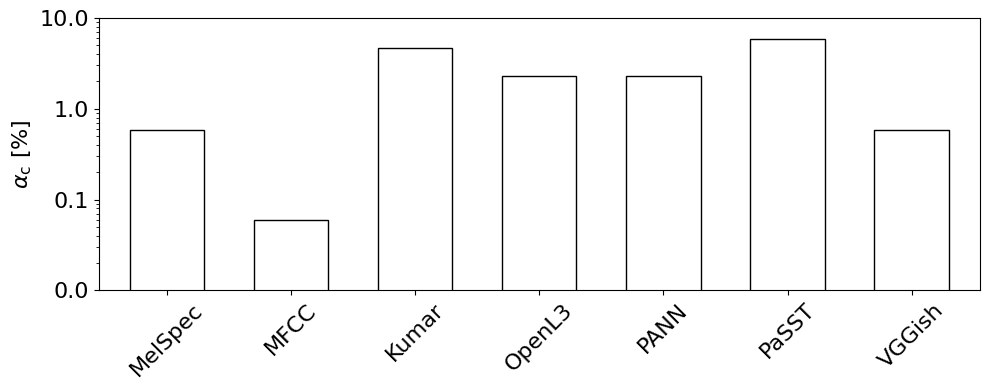

In [27]:
width = 0.4
df = pd.DataFrame(data=compression_rate*100, index=emb_labels, columns=('com',))
fig = pl.figure(figsize=(10,4))
ax = pl.gca()
df.com.plot(kind='bar', 
       color="white",
       edgecolor='black', ax=ax, width=0.6)
pl.gca().set_yscale('log')
pl.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
pl.ylabel(r'$\alpha_\mathrm{c}~[\mathrm{\%}]$', fontsize=fo_si)
pl.ylim((0.01, 10))
xticks = np.arange(n_emb_lab)
pl.gca().tick_params(labelsize=fo_si)
pl.gca().set_xticklabels(pl.gca().get_xticklabels(), rotation=45)
pl.yticks(fontsize=fo_si)
polish_figure()
pl.savefig(os.path.join(dir_results, 'e.png'), dpi=300, bbox_inches='tight')
pl.savefig(os.path.join(dir_results, 'e.eps'), dpi=300, bbox_inches='tight')
pl.show()

In [28]:
print(df)

              com
MelSpec  0.580499
MFCC     0.058957
Kumar    4.643991
OpenL3   2.321995
PANN     2.321995
PaSST    5.873016
VGGish   0.580499


## Inter-correlation strength  $\alpha_\mathrm{i}$ (Sec. V.A.)

Only the **non-augmented** data is considered here.

In [29]:
mean_cc = np.zeros(n_emb_lab)
std_cc = np.zeros(n_emb_lab)

for e, emb_lab in enumerate(emb_labels):
    
    # reshape 
    s = emb_agg_4d[emb_lab].shape
    emb_2d = np.reshape(emb_agg_4d[emb_lab][:,[0, 5],2,:], [s[0]*2, s[3]]).T

    # correlation coefficient
    cc = np.corrcoef(emb_2d)
    
    # focus on absolute correlation value
    cc_abs = np.abs(cc)
    
    # focus on values below the main diagonal (as they indicate cross-embedding inter-correlations)
    idx = np.tril_indices(cc.shape[0], -1)
    mean_cc[e] = np.mean(cc_abs[idx])
    std_cc[e] = np.std(cc_abs[idx])

### Fig. 3

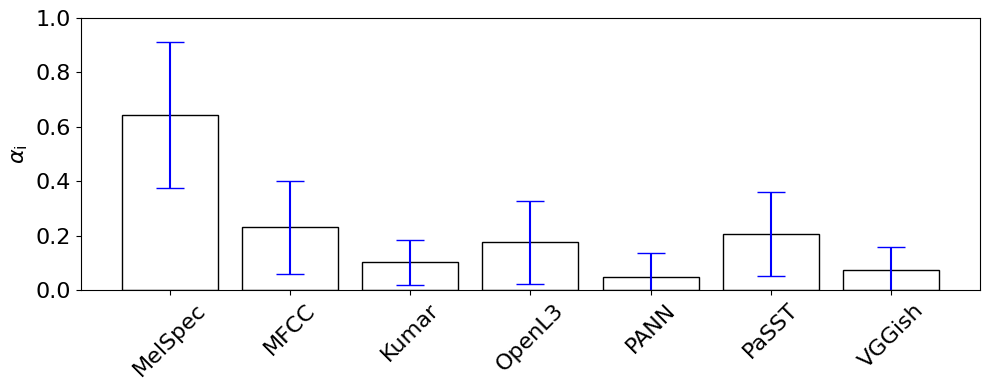

In [30]:
df = pd.DataFrame(data=mean_cc, index=emb_labels, columns=('cc',))
fig = pl.figure(figsize=(10,4))
ax = pl.gca()
ax.bar(np.arange(len(mean_cc)), 
       mean_cc,
       yerr=std_cc,
       align='center',
       color="white",
       edgecolor='black',
       ecolor="blue",
       capsize=10)
pl.ylim(0,1)
pl.xticks(np.arange(len(emb_labels)), emb_labels)
pl.ylabel(r"$\alpha_\mathrm{i}$", fontsize=fo_si)
xticks = np.arange(n_emb_lab)
pl.gca().tick_params(labelsize=fo_si)
pl.gca().set_xticklabels(pl.gca().get_xticklabels(), rotation=45)
pl.yticks(fontsize=fo_si)
polish_figure()
pl.savefig(os.path.join(dir_results, 'cc.png'), dpi=300, bbox_inches='tight')
pl.savefig(os.path.join(dir_results, 'cc.eps'), dpi=300, bbox_inches='tight')
pl.show()

## Class Scatter Ratio $r_{\mathrm{cs}}$

(this was not documented in the article)

In [31]:
def class_scatter_ratio(feat_mat, class_id):
    """ Compute class-scatter ratio
    Args:
        feat_mat (2d np.ndarray): Feature matrix (n_items x n_feat_dims)
        class_id (np.ndarray): Class IDs (n_items)
    Returns:
        bcv (float): Mean between-class variance 
        wcv (float): Mean within-class variance (TODO: rephrase to "scatter" ??)
    """
    
    assert feat_mat.ndim == 2
    
    bcv, wcv = 0, 0    

    # unique class ids
    uids = np.unique(class_id)
    n_classes = len(uids)
    
    n_emb_dims = feat_mat.shape[1]    
    
    # global centroid
    glob_cent = np.mean(feat_mat, axis=0)
    
    # class centroids
    class_cent = np.zeros((n_classes, n_emb_dims))  # 50 x E
    for c, cid in enumerate(uids):
        class_cent[c, :] = np.mean(feat_mat[class_id == cid, :], axis=0)

    # number of examples per class
    n_per_class = np.array([np.sum(class_id == _) for _ in uids])
            
    # between-class scatter = average cosine distance between class centroids and global centroid
    scatter_between = np.mean(latent_space_dist(class_cent, glob_cent))
    
    # within-class scatter = average cosine distance between class items and centroid, 
    
    # within-class scatter
    class_scatter = np.zeros(n_classes)
    for c, cid in enumerate(uids):
        class_scatter[c] = np.mean(latent_space_dist(feat_mat[class_id == cid, :], class_cent[c, :]))
    scatter_within = np.mean(class_scatter)

    return scatter_between, scatter_within

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


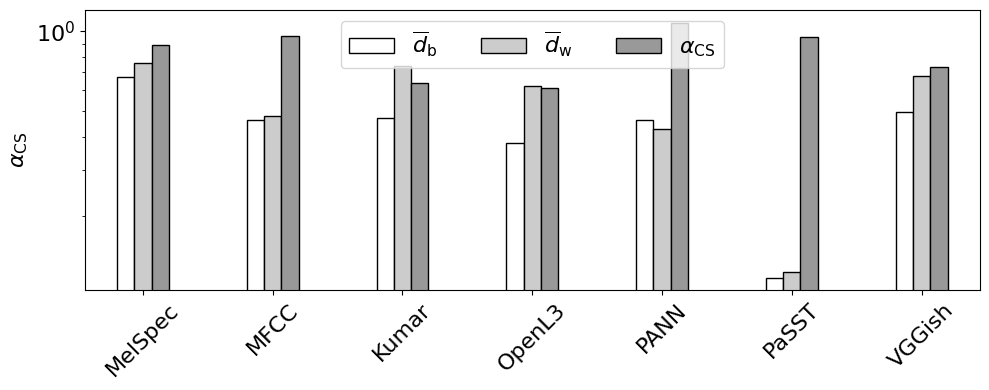

In [32]:
bcv = np.zeros(n_emb_lab)
wcv = np.zeros(n_emb_lab)
mon_emb_classes = {}
mon_emb_stacked = {}

# get class ids of isolated sounds for each sound pair
class_sound_1 = class_id[unique_id_pairs[:, 0]]
class_sound_2 = class_id[unique_id_pairs[:, 1]]

# iterate over audio representations
for e, emb_lab in enumerate(emb_labels):

    # now let's stack the embeddings of all 1000 embeddings with (g=0) which are the ones with the second sounds of each pair
    # and the 1000 embeddings with (g=1) of the first sounds of each embeddings. This gives a total of 2000 embeddings
    
    # all monophonic embedding class ids (g = 0 means that the sound with the class_id 2 is present and g=1 class_id1!)
    mon_emb_classes[emb_lab] = np.concatenate((class_sound_2, class_sound_1))  # (2000, )
    
    # all monophonic embeddings (g = 0 and g = 1)
    mon_emb_stacked[emb_lab] = np.vstack((emb_agg_4d[emb_lab][:, 0, 2, :],
                                          emb_agg_4d[emb_lab][:, 5, 2, :]))  # (2000, E)
    
    # compute scatter ratio
    bcv[e], wcv[e] = class_scatter_ratio(mon_emb_stacked[emb_lab], mon_emb_classes[emb_lab])
    
ratio = bcv / wcv

pl.figure(figsize=(10, 4))
xticks = np.arange(n_emb_lab)
df = pd.DataFrame(data=np.array([bcv, wcv, ratio]).T, 
                  index=emb_labels, 
                  columns=(r'$\overline{d}_\mathrm{b}$', r'$\overline{d}_\mathrm{w}$', r'$\alpha_\mathrm{CS}$'))
ax = pl.gca()
df.plot(kind='bar', color=[[1, 1, 1], [0.8, .8, .8], [.6, .6, .6]],
       edgecolor='black', ax=ax, width=width)
pl.ylabel(r"$\alpha_\mathrm{CS}$", fontsize=fo_si)
xticks = np.arange(n_emb_lab)
pl.gca().tick_params(labelsize=fo_si)
pl.gca().set_xticklabels(pl.gca().get_xticklabels(), rotation=45)
pl.yticks(fontsize=fo_si)
pl.legend((r'$\overline{d}_\mathrm{b}$', r'$\overline{d}_\mathrm{w}$', r'$\alpha_\mathrm{CS}$'), fontsize=fo_si, ncol=3)
pl.gca().set_yscale('log')
polish_figure()
pl.savefig(os.path.join(dir_results, 'class_scatter_ratio.png'), dpi=300, bbox_inches='tight')
pl.savefig(os.path.join(dir_results, 'class_scatter_ratio.eps'), dpi=300, bbox_inches='tight')
pl.show()

## Dunn Index (DI) & Davies-Bouldin Index (DBI) (Sec. V.B)

In [33]:
def dunn_index(feat_mat, class_id):
    """ Compute Dunn index as goodness-measures for given clustering
    Refs:
        - Dunn, J. C. (1973-09-17). "A Fuzzy Relative of the ISODATA Process and Its Use in 
          Detecting Compact Well-Separated Clusters". Journal of Cybernetics. 3 (3): 32–57. 
        - https://en.wikipedia.org/wiki/Dunn_index
    Args:
        feat_mat (2d np.ndarray): Feature matrix (n_items x n_feat_dims)
        class_id (np.ndarray): Class IDs (n_items)
    Returns:
        di (float): Dunn index (DI)
    """
    
    assert feat_mat.ndim == 2

    n_emb_dims = feat_mat.shape[1]    

    # unique class ids
    uids = np.unique(class_id)
    n_classes = len(uids)
    
    # class centroids
    class_cent = np.zeros((n_classes, n_emb_dims))  # 50 x E
    for c, cid in enumerate(uids):
        class_cent[c, :] = np.mean(feat_mat[class_id == cid, :], axis=0)
    
    # intracluster distance = average distance of all class instances to their centroid
    intra_cluster_dist = np.zeros(n_classes)
    for c in range(n_classes):
        pair_wise_dist = latent_space_dist(feat_mat[class_id == cid, :], class_cent[c, :])
        intra_cluster_dist[c] = np.mean(pair_wise_dist)
        
    # intercluster distance
    inter_cluster_dist = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            inter_cluster_dist[c1, c2] = latent_space_dist(class_cent[c1, :][np.newaxis, :], 
                                                           class_cent[c2, :][np.newaxis, :])
    
    # entries below main diagonal
    idx = np.tril_indices(inter_cluster_dist.shape[0], -1)
    
    # Dunn index
    di = np.min(inter_cluster_dist[idx]) / np.max(intra_cluster_dist)

    return di 


In [34]:
def davies_bouldin_index(feat_mat, class_id):
    """ Compute Goodness-measures for given clustering:
        - Davies-Bouldin Index
    Refs:
        - Davies, David L.; Bouldin, Donald W. (1979). "A Cluster Separation Measure". 
          IEEE Transactions on Pattern Analysis and Machine Intelligence. PAMI-1 (2): 224–227.
        - https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
    Args:
        feat_mat (2d np.ndarray): Feature matrix (n_items x n_feat_dims)
        class_id (np.ndarray): Class IDs (n_items)
    Returns:
        dbi (float): Davies-Bouldin Index (DBI): DBI > 0 (the smaller DBI, the better is the class separability)
    """
    assert feat_mat.ndim == 2

    n_emb_dims = feat_mat.shape[1]    

    # unique class ids
    uids = np.unique(class_id)
    n_classes = len(uids)
    
    # class centroids
    class_cent = np.zeros((n_classes, n_emb_dims))  # 50 x E
    for c, cid in enumerate(uids):
        class_cent[c, :] = np.mean(feat_mat[class_id == cid, :], axis=0)
    
    # intracluster distance = average distance of all class instances to their centroid
    intra_cluster_dist = np.zeros(n_classes)
    for c in range(n_classes):
        pair_wise_dist = latent_space_dist(feat_mat[class_id == cid, :], class_cent[c, :])
        intra_cluster_dist[c] = np.mean(pair_wise_dist)
        
    # intercluster distance
    inter_cluster_dist = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            inter_cluster_dist[c1, c2] = latent_space_dist(class_cent[c1, :][np.newaxis, :], 
                                                           class_cent[c2, :][np.newaxis, :])
    
    # pairwise cluster similarity
    R = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            if c1 != c2:
                R[c1, c2] = (intra_cluster_dist[c1] + intra_cluster_dist[c2]) / inter_cluster_dist[c1, c2]

    # worst-case approach: take most similar other class to each class
    worst_sim = np.zeros(n_classes)
    for c in range(n_classes):
        worst_sim[c] = np.max(R[c, :])
        
    # Davies-Bouldin index
    dbi = np.mean(worst_sim)
    
    return 1/dbi


In [35]:
di = np.zeros(n_emb_lab)
di2 = np.zeros(n_emb_lab)
dbi = np.zeros(n_emb_lab)
mon_emb_classes = {}
mon_emb_stacked = {}

# get class ids of isolated sounds for each sound pair
class_sound_1 = class_id[unique_id_pairs[:, 0]]
class_sound_2 = class_id[unique_id_pairs[:, 1]]

# iterate over audio representations
for e, emb_lab in enumerate(emb_labels):

    # now let's stack the embeddings of all 1000 embeddings with (g=0) which are the ones with the second sounds of each pair
    # and the 1000 embeddings with (g=1) of the first sounds of each embeddings. This gives a total of 2000 embeddings
    
    # all monophonic embedding class ids (g = 0 means that the sound with the class_id 2 is present and g=1 class_id1!)
    mon_emb_classes[emb_lab] = np.concatenate((class_sound_2, class_sound_1))  # (2000, )
    
    # all monophonic embeddings (g = 0 and g = 1)
    mon_emb_stacked[emb_lab] = np.vstack((emb_agg_4d[emb_lab][:, 0, 2, :],
                                          emb_agg_4d[emb_lab][:, 5, 2, :]))  # (2000, E)
    
    # compute goodness measures for class clustering in latent space
    di[e] = dunn_index(mon_emb_stacked[emb_lab], mon_emb_classes[emb_lab])
    dbi[e] = davies_bouldin_index(mon_emb_stacked[emb_lab], mon_emb_classes[emb_lab])



### Fig. 5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


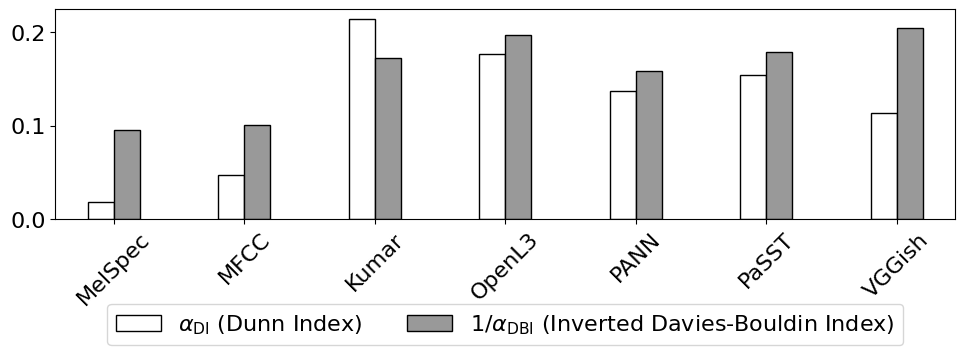

In [36]:
pl.figure(figsize=(10, 4))
xticks = np.arange(n_emb_lab)
df = pd.DataFrame(data=np.array([di, dbi]).T, 
                  index=emb_labels, 
                  columns=(r'$DI$', r'$1/DBI$'))
ax = pl.gca()
df.plot(kind='bar', color=[[1, 1, 1], [.6, .6, .6]],
       edgecolor='black', ax=ax, width=width)
#pl.ylabel(r"$\alpha_\mathrm{CS}$", fontsize=fo_si)
xticks = np.arange(n_emb_lab)
pl.gca().tick_params(labelsize=fo_si)
pl.gca().set_xticklabels(pl.gca().get_xticklabels(), rotation=45)
pl.yticks(fontsize=fo_si)
pl.legend((r'$\alpha_\mathrm{DI}$ (Dunn Index)', r'$1/\alpha_\mathrm{DBI}$ (Inverted Davies-Bouldin Index)'), 
          fontsize=fo_si, ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.35))
#pl.gca().set_yscale('log')
polish_figure()
pl.savefig(os.path.join(dir_results, 'di_dbi.png'), dpi=300, bbox_inches='tight')
pl.savefig(os.path.join(dir_results, 'di_dbi.eps'), dpi=300, bbox_inches='tight')
pl.show()


## Robustness to augmentations (Sec. VI)



In [37]:
def compute_centroids(feat_mat, class_id):
    uids = np.sort(np.unique(class_id))
    n_classes = len(uids)
    n_dim = feat_mat.shape[1]
    centroids = np.zeros((n_classes, n_dim), dtype=np.float32)
    for u, uid in enumerate(uids):
        centroids[u, :] = np.mean(feat_mat[class_id == uid, :], axis=0)
    return centroids, uids

In [38]:
# focus on non-augmented isolated sounds again (no mixtures)
n_conf = len(emb_labels)
n_samples = 2000
n_augs = 4
aug_idx = [0, 1, 3, 4]  # we don't care about "clean" here

aug_labs = ['BoostHigh', 'BoostLow', 'Noise', 'Quiet']

psi_ca_all = np.zeros((n_conf, n_samples, n_augs), dtype=np.float32)
psi_cc_all = np.zeros((n_conf, n_samples, n_augs), dtype=np.float32)

#. iterate over audio representations
for e, emb_lab in enumerate(emb_labels):

    #. compute class centroids for non-augmented embeddings
    centroids, uids = compute_centroids(mon_emb_stacked[emb_lab], mon_emb_classes[emb_lab])

    #. iterate over augmentations
    for a in range(n_augs):
        
        # current augmentation index (since we do not consider all of them)
        cur_aug_idx = aug_idx[a]
        
        #. prepare stacked embedding matrix for current augmentation
        aug_emb_stacked = np.vstack((emb_agg_4d[emb_lab][:, 0, cur_aug_idx, :],
                                     emb_agg_4d[emb_lab][:, 5, cur_aug_idx, :]))
        
        #. iterate over samples
        for s in range(2000):
            
            #. class ID of current sample
            cur_class_id = mon_emb_classes[emb_lab][s]
            
            # distance between augmented and clean embedding
            psi_ca_all[e, s, a] = latent_space_dist(aug_emb_stacked[s, :], mon_emb_stacked[emb_lab][s, :])
            
            # difference between clean-to-centroid and augmented-to-centroid distances 
            psi_cc_all[e, s, a] = latent_space_dist(mon_emb_stacked[emb_lab][s, :], centroids[cur_class_id, :]) - \
                                  latent_space_dist(aug_emb_stacked[s, :], centroids[cur_class_id, :])

# compute mean and standard deviation over all samples
psi_ca_mn = np.mean(psi_ca_all, axis=1)
psi_cc_mn = np.mean(psi_cc_all, axis=1)
psi_ca_sd = np.std(psi_ca_all, axis=1)
psi_cc_sd = np.std(psi_cc_all, axis=1)
  

### Fig. 7

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


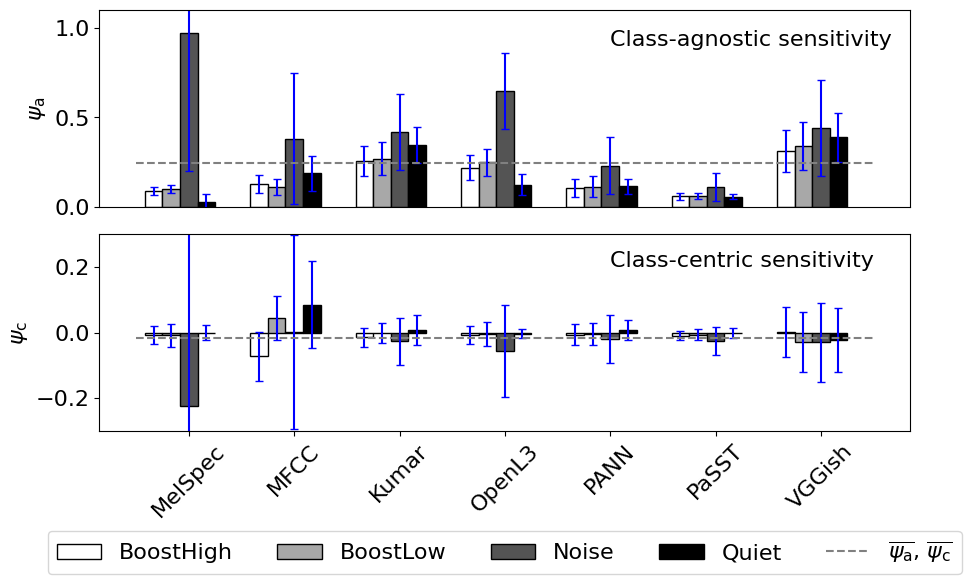

In [39]:
n_emb = len(emb_labels)
x = np.arange(n_conf)
dx = (np.arange(n_augs)-n_augs/2.)/(n_augs+2.)
d = 1./(n_augs+2.)
cols = 1- np.arange(4)/8
cols = [(_, _, _) for _ in cols]
cols = [[1,1,1], [.66,.66,.66], [.33, .33, .33], [0, 0, 0]]

fig, axs = pl.subplots(2)
fig.set_size_inches(10, 6)

for a in range(n_augs):
    axs[0].bar(x+dx[a],
               psi_ca_mn[:, a], 
               yerr=psi_ca_sd[:, a],
               align='center',
               color="white",
               edgecolor='black',
               ecolor="blue",
               capsize=3,
               width=d, 
               label=aug_labs[a],
               fc=cols[a])
axs[0].set_ylabel('$\psi_\mathrm{a}$', fontsize=fo_si)
axs[0].yaxis.set_tick_params(labelsize=fo_si)
axs[0].set_xticks([], minor=True)
axs[0].set_xticks([])
mean_val = np.mean(psi_ca_mn)
axs[0].plot([x[0]-.5, x[-1]+.5], [mean_val, mean_val], linestyle='--', color=[.5,.5,.5], label='$\overline{\psi_\mathrm{a}}$, $\overline{\psi_\mathrm{c}}$')
axs[0].text(4, .9, 'Class-agnostic sensitivity', fontsize=fo_si, horizontalalignment='left')
# axs[0].set_yscale('symlog')
axs[0].set_ylim((0, 1.1))
# pl.ylim((0, 1.1))

for a in range(n_augs):
    axs[1].bar(x+dx[a],
               psi_cc_mn[:, a], 
               yerr=psi_cc_sd[:, a],
               align='center',
               color="white",
               edgecolor='black',
               ecolor="blue",
               capsize=3,
               width=d, 
               label=aug_labs[a],
               fc=cols[a])
axs[1].set_ylabel('$\psi_\mathrm{c}$', fontsize=fo_si)
axs[1].yaxis.set_tick_params(labelsize=fo_si)
# axs[1].set_yticks([0, 0.05, 0.1, 0.15])
xticks = np.arange(n_emb_lab)
axs[1].tick_params(labelsize=fo_si)
axs[1].set_ylim((-0.3, 0.3))
axs[1].set_xticks(np.arange(n_emb))
axs[1].set_xticklabels(emb_labels, rotation=45, fontsize=fo_si)
axs[1].text(4, 0.2, 'Class-centric sensitivity', fontsize=fo_si, horizontalalignment='left')

mean_val = np.mean(psi_cc_mn)
axs[1].plot([x[0]-.5, x[-1]+.5], [mean_val, mean_val], linestyle='--', color=[.5,.5,.5])

# resort legend entries
handles, labels = axs[0].get_legend_handles_labels()
order = [1,2,3,4,0]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=5, fontsize=fo_si, 
              loc='upper center', bbox_to_anchor=(0.5, -0.45))

pl.tight_layout()
pl.savefig(os.path.join(dir_results, 'robust.png'), dpi=300, bbox_inches='tight')
pl.savefig(os.path.join(dir_results, 'robust.eps'), dpi=300, bbox_inches='tight')
pl.show()


## (1) Visualize embedding trajectories for sound blends

(this was not documented in the article)

In [40]:
# helper functions to transform 2D into 3D embedding matrices and vice versa
def reshape_2d_to_3d(emb_2d, n_gain_steps=6):
    n_emb, emb_len = emb_2d.shape
    return emb_2d.reshape(n_emb//n_gain_steps, n_gain_steps, emb_len)

def reshape_3d_to_2d(emb_3d):
    n_emb, n_gain, emb_len = emb_3d.shape
    return emb_3d.reshape(n_emb * n_gain, emb_len)

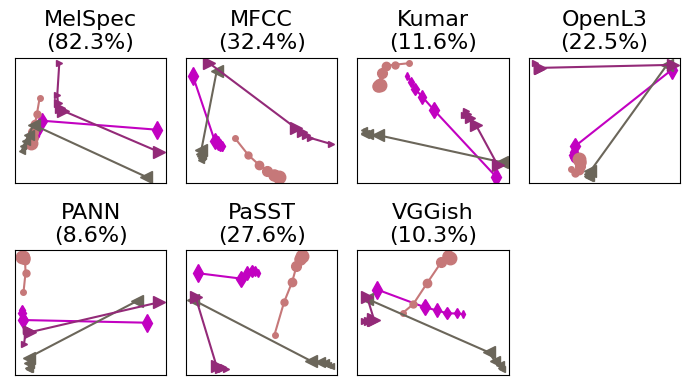

In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# use = 'tsne'
use = 'pca'

if use not in ('tsne', 'pca'):
    raise ValueError

colors = np.random.rand(70,3)*0.8
markers = ['d', 'o', '<', '>', 's', '^', '.']*10

g_val = [0, .2, .4, .6, .8, 1]
g_lab = ['0', '0.2', '0.4', '0.6', '0.8', '1']


pl.figure(figsize=(7, 4))

mod_emb_labels = emb_labels

for e, emb_lab in enumerate(emb_labels):

    pl.subplot(2, 4,e+1)
    
    # pre-processing (standardization + dimensionality reduction)
    emb = np.copy(emb_agg_4d[emb_lab][:, :, 2, :])  # item x g x emb
    emb_2d = reshape_3d_to_2d(emb)
    emb_2d = StandardScaler().fit_transform(emb_2d)
    if use == 'pca':
        pca = PCA(n_components=2).fit(emb_2d)
        emb_2d = pca.transform(emb_2d)
        # print(pca.explained_variance_ratio_)
        var_explained = np.sum(pca.explained_variance_ratio_)
    else:
        emb_2d = TSNE(n_components=2, perplexity=50).fit_transform(emb_2d)
    emb = reshape_2d_to_3d(emb_2d)

    # plot sound blend trajectories
    for i in range(4):
        curr_emb = emb[i, :, :]
        pl.plot(curr_emb[:, 0], curr_emb[:, 1], color=colors[i, :], marker=None, linestyle='-')
        for b in range(6):
            pl.plot(curr_emb[b, 0], curr_emb[b, 1], color=colors[i, :], marker=markers[i], markersize=4+b)
    pl.title(mod_emb_labels[e] + "\n({:2.1f}%)".format(100*var_explained), fontsize=fo_si)
    pl.gca().axes.xaxis.set_visible(False)
    pl.gca().axes.yaxis.set_visible(False)

polish_figure()
pl.savefig(os.path.join(dir_results, 'pca_emb_sound_blends.eps'), dpi=300)
pl.savefig(os.path.join(dir_results, 'pca_emb_sound_blends.png'), dpi=300)
pl.show()
        


## Sound blending embedding space trajectories (Sec. VII.A)



In [42]:
n_pairs = 1000
n_classes = 50
all_class_ids = np.arange(n_classes)

g = np.arange(0, 6)/5

mn = dict()
sd = dict()
mn1 = dict()
sd1 = dict()
mn2 = dict()
sd2 = dict()
mn_other = dict()
sd_other = dict()

all_idx = np.arange(n_pairs)

# needed for further analysis
dist_to_centroids_pann = []

# iterate over audio representations
for e, emb_lab in enumerate(emb_labels):

    # current embedding dimensions
    n_emb_cur = mon_emb_stacked[emb_lab].shape[1]
    
    # compute class centroids for non-augmented embeddings
    centroids, uids = compute_centroids(mon_emb_stacked[emb_lab], mon_emb_classes[emb_lab])

    # distances between the mixture embeddings to the corresponding class centroids
    dist_to_centroids = np.zeros((n_pairs, 2, 6)) 
    
    # distances between the mixture embedding and the closest out-of-class centroid (from another class)
    dist_to_ooc = np.zeros((n_pairs, 6))
    
    # corresponding ooc class indices
    dist_to_ooc_class_idx = np.zeros((n_pairs, 6))
    
    # emb_agg_4d.shape: 1000 x 6 (Gain) x 5 (aug) x E

    # iterate over all sound pairs
    for f in range(n_pairs):

        #. 6 embedding vectors for current sound pair (non-degraded versions!)
        cur_emb = emb_agg_4d[emb_lab][f, :, 2, :] # 6 x n_dim

        #. in-class centroids for both isolated sounds in current sound pair
        centroids_ic = np.zeros((2, n_emb_cur))
        centroids_ic[0, :] = centroids[uids==class_sound_2[f]]  # for g = 0 -> second class is present
        centroids_ic[1, :] = centroids[uids==class_sound_1[f]]  # for g = 1 -> first class is present
        
        #. out-of-class (OOC) indices
        class_idx_ooc = np.logical_not(np.isin(uids, [class_sound_1[f], class_sound_2[f]]))
        
        # OOC centroids
        centroids_ooc = centroids[class_idx_ooc, :]
        n_ooc = centroids_ooc.shape[0]

        # iterate over mixtures
        for i in range(6):
            
            # compute distance between mixture embeddings and corresponding class centroids
            dist_to_centroids[f, 0, i] = latent_space_dist(cur_emb[i, :], centroids_ic[0, :])
            dist_to_centroids[f, 1, i] = latent_space_dist(cur_emb[i, :], centroids_ic[1, :])

            #. distance to OOC embeddings
            dist_mat = latent_space_dist(cur_emb[i, :], centroids_ooc)
            
            # save closest distance (d^*) and corresponding class 
            dist_to_ooc[f, i] = np.min(dist_mat)
            dist_to_ooc_class_idx[f, i] = np.argmin(dist_mat)

    dist_min = np.min(dist_to_centroids, axis=1) 
    mn[emb_lab] = np.mean(dist_min, axis=0)
    sd[emb_lab] = np.std(dist_min, axis=0)
    
    dist_min_sound_1 = dist_to_centroids[:, 0, :]
    dist_min_sound_2 = dist_to_centroids[:, 1, :]
    mn1[emb_lab] = np.mean(dist_min_sound_1, axis=0)
    sd1[emb_lab] = np.std(dist_min_sound_1, axis=0)
    mn2[emb_lab] = np.mean(dist_min_sound_2, axis=0)
    sd2[emb_lab] = np.std(dist_min_sound_2, axis=0)

    
    
    mn_other[emb_lab] = np.mean(dist_to_ooc, axis=0)
    sd_other[emb_lab] = np.std(dist_to_ooc, axis=0)
    
    if emb_lab == "PANN":
        dist_to_centroids_pann = np.copy(dist_to_centroids)

### Fig. 9

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


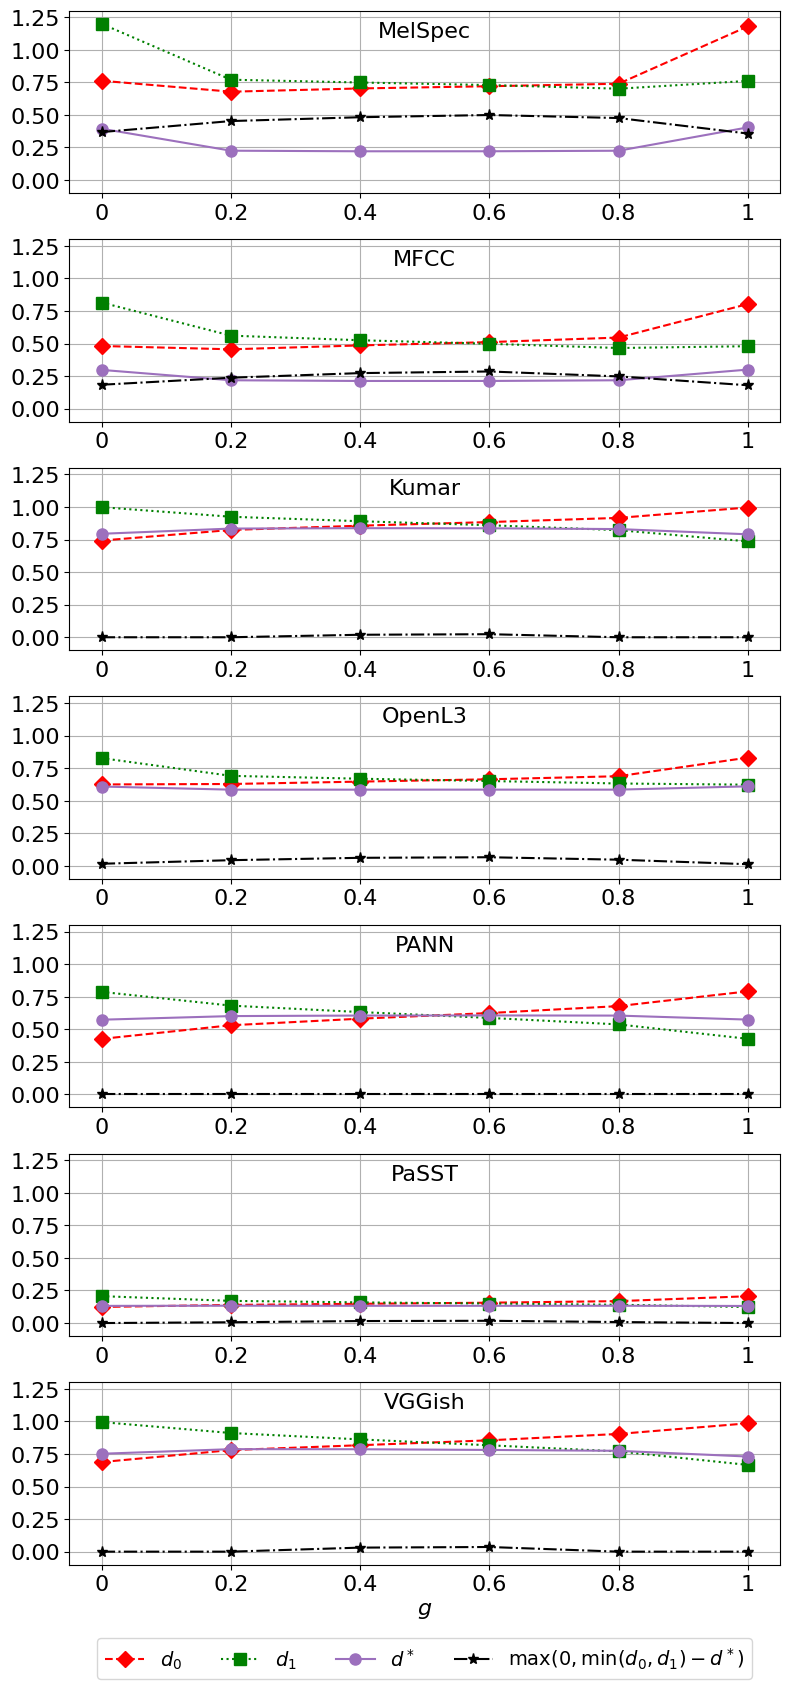

In [43]:
pl.figure(figsize=(8, 17))

n_emb = len(emb_labels)

# iterate over audio representations
for e, emb_lab in enumerate(emb_labels):

    pl.subplot(7,1,e+1)
    col = np.array([_/255 for _ in [84, 130, 53]]) # green
    colbg = 1 - 0.3*(1-col)

    pl.plot(g, mn1[emb_lab], marker='D', linestyle='--', color='r', label='$d_0$', markersize=8)
    pl.plot(g, mn2[emb_lab], marker='s', linestyle=':', color='g', label='$d_1$', markersize=8)

    # replace title by text block in figure
    pl.text(0.5, 1.1, emb_lab, fontsize=fo_si, horizontalalignment='center')
    
    # closest distance to mE's
    col = np.array([_/255 for _ in [156, 112, 189]]) # lavendel
    colbg = 1 - 0.3*(1-col)
    pl.plot(g, mn_other[emb_lab], marker='o', linestyle='-', color=col, label='$d^*$', markersize=8)
    
    # additional plot (confusion risk)
    risk = np.min(np.stack((mn1[emb_lab], mn2[emb_lab])), axis=0) - mn_other[emb_lab]
    risk[risk < 0] = 0
    
    pl.plot(g, risk, marker='*', linestyle='-.', color='k', label='$\max(0, \min(d_0, d_1) - d^*)$', markersize=8)
    
    # only show x label for lower subplot
    if e == n_emb - 1:
        pl.xlabel('$g$', fontsize=fo_si)
    pl.ylabel('')

    pl.xticks(g_val, g_lab)
    if e == 6:
        pl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), 
                  ncol=4, fontsize=fo_si-2)
    
    pl.ylim(-.1, 1.3)
    pl.grid(True)
    
    polish_figure()
pl.tight_layout()
pl.savefig(os.path.join(dir_results, 'cosine_dist_sound_blends.png'), dpi=300, bbox_inches='tight')
pl.savefig(os.path.join(dir_results, 'cosine_dist_sound_blends.eps'), dpi=300, bbox_inches='tight')
pl.show()


## SET experiment based on the embeddings (Sec. VII.B)

In [44]:
def create_model(n_in, n_classes=50):
    """ Simple MLP model """
    inp = tf.keras.layers.Input(shape=(n_in,))
    x = tf.keras.layers.Dense(128, activation="relu")(inp)
    out = tf.keras.layers.Dense(n_classes, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    return model

### Multi-label classification, MLP classifier

In [45]:
# train-test split 800:200
idx = np.arange(1000)
idx_train = idx[:800]
idx_test = idx[800:]
n_test_files = len(idx_test)

n_train_samples_per_gain = 800
n_test_samples_per_gain = 200

mAP = np.zeros((len(emb_labels), 3))

# train and evaluate MLP for each embedding
for e, emb_lab in enumerate(emb_labels):
    
    print(f"Process embedding {emb_lab} ...")

    # select non-degraded version
    emb = emb_agg_4d[emb_lab][:, :, 2, :]

    # training data
    # concatenate all embedding matrices with all gain factors from the training examples
    X_train = np.vstack([emb[idx_train, g, :] for g in range(6)])
    n_samples = X_train.shape[0]
    
    # training targets (mix of single-class and multi-class annotations)
    X_targets_train = np.zeros((n_samples, 50), dtype=np.int8)
    for gain in range(6):
        offset = gain*n_train_samples_per_gain
        for s in range(n_train_samples_per_gain):
            if gain < 5:
                X_targets_train[offset + s, class_sound_2[idx_train[s]]] = 1
            if gain > 1:
                X_targets_train[offset + s, class_sound_1[idx_train[s]]] = 1
    
    # test data
    # concatenate all embedding matrices with all gain factors from the training examples
    X_test = np.vstack([emb[idx_test, g, :] for g in range(6)])
    n_samples = X_test.shape[0]
    
    # training targets (mix of single-class and multi-class annotations)
    X_targets_test = np.zeros((n_samples, 50), dtype=np.int8)
    gain_targets_test = np.zeros(n_samples, dtype=np.int8)
    for gain in range(6):
        offset = gain*n_test_samples_per_gain
        for s in range(n_test_samples_per_gain):
            if gain < 5:
                X_targets_test[offset + s, class_sound_2[idx_test[s]]] = 1
            if gain > 1:
                X_targets_test[offset + s, class_sound_1[idx_test[s]]] = 1
            gain_targets_test[offset + s] = gain
        np.sum(gain_targets_test == gain)
            
    model = create_model(n_in = X_train.shape[1])
   #  model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    model.compile(loss = 'binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[])
    
    model.fit(X_train, X_targets_train, batch_size=32, epochs=150, verbose=0, validation_split=0.2, callbacks=[callback])
    
    test_scores = model.predict(X_test)
    
    idx = np.logical_or(gain_targets_test == 0, gain_targets_test == 5)
    mAP[e, 0] = average_precision_score(X_targets_test[idx], test_scores[idx])

    idx = np.logical_or(gain_targets_test == 1, gain_targets_test == 4)
    mAP[e, 1] = average_precision_score(X_targets_test[idx], test_scores[idx])

    idx = np.logical_or(gain_targets_test == 2, gain_targets_test == 3)
    mAP[e, 2] = average_precision_score(X_targets_test[idx], test_scores[idx])
    




Process embedding MelSpec ...
Process embedding MFCC ...
Process embedding Kumar ...
Process embedding OpenL3 ...
Process embedding PANN ...
Process embedding PaSST ...
Process embedding VGGish ...


### Fig. 10

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


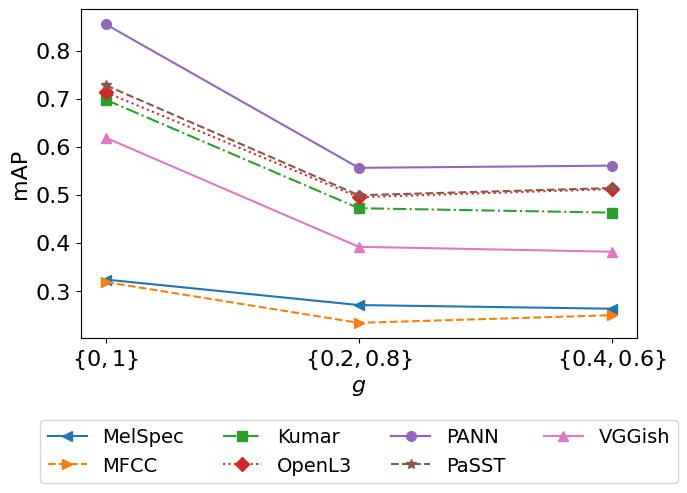

In [46]:
pl.figure(figsize=(7,5))
m = ('<', '>', 's', 'D', 'o', '*', '^')
ls = ('-', '--', '-.', ':','-', '--', '-')
for e, emb_lab in enumerate(emb_labels):
    pl.plot([0, 1, 2], mAP[e, :], marker=m[e], label=emb_lab, markersize=7, linestyle=ls[e])
pl.xticks((0, 1, 2), (r'$\left\{0, 1\right\}$', 
                      r'$\left\{0.2, 0.8\right\}$', 
                      r'$\left\{0.4, 0.6\right\}$'), fontsize=fo_si)
pl.xlabel('$g$', fontsize=fo_si)
pl.ylabel('mAP', fontsize=fo_si)
pl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.22), 
                  ncol=4, fontsize=fo_si-2)
polish_figure()
pl.tight_layout()
pl.savefig(os.path.join(dir_results, 'classification_exp.png'), dpi=300)
pl.savefig(os.path.join(dir_results, 'classification_exp.eps'), dpi=300)
pl.show()

That's all :)